In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.spatial import Voronoi, voronoi_plot_2d

# Uniform Random Sampling
Put points at random for a uniform distribution.

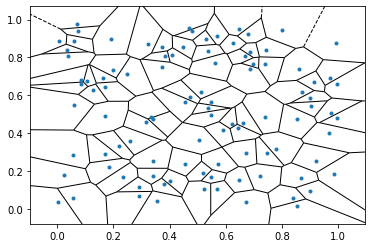

In [12]:
num = 100
points = np.random.random(size=(num, 2))

vor = Voronoi(points)
fig = voronoi_plot_2d(vor=vor, show_vertices=False)

plt.show()

# Poisson Disk Sampling

Code is taken from
https://scipython.com/blog/poisson-disc-sampling-in-python/
or
https://github.com/scipython/scipython_maths/tree/master/poisson_disc_sampled_noise

The algortihm is based on "Fast Poisson Disk Sampling in Arbitrary Dimensions" by Robert Bridson
https://www.cs.ubc.ca/~rbridson/docs/bridson-siggraph07-poissondisk.pdf

Set the parameters for the minimum distance between points. This basically controlls the density.

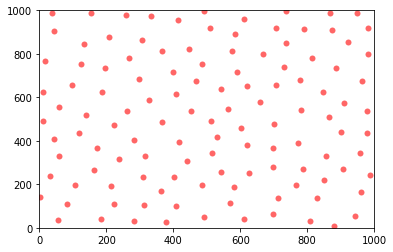

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Choose up to k points around each reference point as candidates for a new
# sample point
k = 30

# Minimum distance between samples
r = 75.0

width, height = 1000, 1000

# Cell side length
a = r/np.sqrt(2)
# Number of cells in the x- and y-directions of the grid
nx, ny = int(width / a) + 1, int(height / a) + 1

# A list of coordinates in the grid of cells
coords_list = [(ix, iy) for ix in range(nx) for iy in range(ny)]
# Initilalize the dictionary of cells: each key is a cell's coordinates, the
# corresponding value is the index of that cell's point's coordinates in the
# samples list (or None if the cell is empty).
cells = {coords: None for coords in coords_list}

def get_cell_coords(pt):
    """Get the coordinates of the cell that pt = (x,y) falls in."""

    return int(pt[0] // a), int(pt[1] // a)

def get_neighbours(coords):
    """Return the indexes of points in cells neighbouring cell at coords.

    For the cell at coords = (x,y), return the indexes of points in the cells
    with neighbouring coordinates illustrated below: ie those cells that could 
    contain points closer than r.

                                     ooo
                                    ooooo
                                    ooXoo
                                    ooooo
                                     ooo

    """

    dxdy = [(-1,-2),(0,-2),(1,-2),(-2,-1),(-1,-1),(0,-1),(1,-1),(2,-1),
            (-2,0),(-1,0),(1,0),(2,0),(-2,1),(-1,1),(0,1),(1,1),(2,1),
            (-1,2),(0,2),(1,2),(0,0)]
    neighbours = []
    for dx, dy in dxdy:
        neighbour_coords = coords[0] + dx, coords[1] + dy
        if not (0 <= neighbour_coords[0] < nx and
                0 <= neighbour_coords[1] < ny):
            # We're off the grid: no neighbours here.
            continue
        neighbour_cell = cells[neighbour_coords]
        if neighbour_cell is not None:
            # This cell is occupied: store this index of the contained point.
            neighbours.append(neighbour_cell)
    return neighbours

def point_valid(pt):
    """Is pt a valid point to emit as a sample?

    It must be no closer than r from any other point: check the cells in its
    immediate neighbourhood.

    """

    cell_coords = get_cell_coords(pt)
    for idx in get_neighbours(cell_coords):
        nearby_pt = samples[idx]
        # Squared distance between or candidate point, pt, and this nearby_pt.
        distance2 = (nearby_pt[0]-pt[0])**2 + (nearby_pt[1]-pt[1])**2
        if distance2 < r**2:
            # The points are too close, so pt is not a candidate.
            return False
    # All points tested: if we're here, pt is valid
    return True

def get_point(k, refpt):
    """Try to find a candidate point relative to refpt to emit in the sample.

    We draw up to k points from the annulus of inner radius r, outer radius 2r
    around the reference point, refpt. If none of them are suitable (because
    they're too close to existing points in the sample), return False.
    Otherwise, return the pt.

    """
    i = 0
    while i < k:
        rho, theta = np.random.uniform(r, 2*r), np.random.uniform(0, 2*np.pi)
        pt = refpt[0] + rho*np.cos(theta), refpt[1] + rho*np.sin(theta)
        if not (0 <= pt[0] < width and 0 <= pt[1] < height):
            # This point falls outside the domain, so try again.
            continue
        if point_valid(pt):
            return pt
        i += 1
    # We failed to find a suitable point in the vicinity of refpt.
    return False

# Pick a random point to start with.
pt = (np.random.uniform(0, width), np.random.uniform(0, height))
samples = [pt]
# Our first sample is indexed at 0 in the samples list...
cells[get_cell_coords(pt)] = 0
# ... and it is active, in the sense that we're going to look for more points
# in its neighbourhood.
active = [0]

nsamples = 1
# As long as there are points in the active list, keep trying to find samples.
while active:
    # choose a random "reference" point from the active list.
    idx = np.random.choice(active)
    refpt = samples[idx]
    # Try to pick a new point relative to the reference point.
    pt = get_point(k, refpt)
    if pt:
        # Point pt is valid: add it to the samples list and mark it as active
        samples.append(pt)
        nsamples += 1
        active.append(len(samples)-1)
        cells[get_cell_coords(pt)] = len(samples) - 1
    else:
        # We had to give up looking for valid points near refpt, so remove it
        # from the list of "active" points.
        active.remove(idx)

plt.scatter(*zip(*samples), color='r', alpha=0.6, lw=0)
plt.xlim(0, width)
plt.ylim(0, height)
#plt.axis('off')
plt.show()

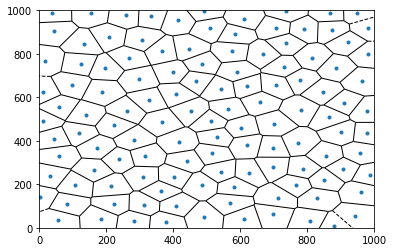

In [31]:
vor = Voronoi(samples)
fig = voronoi_plot_2d(vor=vor, show_vertices=False)

plt.xlim(0, width)
plt.ylim(0, height)
plt.show()

# Dart throwing algorithm

In [113]:
# Minimum distance between points
r = 0.25

points_x = np.array([])
points_y = np.array([])
sec = np.array([])

# The points don't have be inside the emitter area.
# Set how much they can protrude outside it.
# That is the can be in [a, b).
a = -0.025
b = 1.025

# Start by picking one random point
p_x = (b - a)*np.random.random() + a
p_y = (b - a)*np.random.random() + a
num_points = 1
points_x = np.append(points_x, p_x)
points_y = np.append(points_y, p_y)
sec = np.append(sec, num_points)
tries = 0

while True:
    # Stop the loop if we have to many failed tries.
    if (tries > 1000):
        break
        
    # Pick a random point
    p_x = (b - a)*np.random.random() + a
    p_y = (b - a)*np.random.random() + a
    
    accept = True # Set to true then set to false if we find a points to close
    
    # Calculate the distance to all other points and check it
    for pp_x, pp_y in zip(points_x, points_y):
        d = np.sqrt( (pp_x - p_x)**2 + (pp_y - p_y)**2 )
        
        if (d < r): # Check it the distance is smaller than our min distance
            tries = tries + 1
            accept = False # Reject this points
    
    if (accept == True): # Check if we rejected the point
        num_points = num_points + 1
        points_x = np.append(points_x, p_x)
        points_y = np.append(points_y, p_y)
        sec = np.append(sec, num_points)

# Set the work function from a normal distribution.
work_fun = np.random.normal(loc=2.25, scale=0.15, size=num_points)

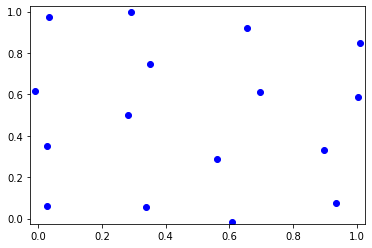

In [114]:
plt.plot(points_x, points_y, 'ob')
plt.xlim(a, b)
plt.ylim(a, b)
plt.show()

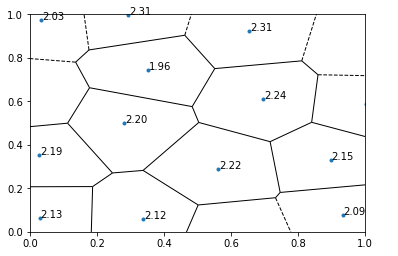

In [115]:
points = np.array(list(zip(points_x, points_y)))
vor = Voronoi(points)
fig = voronoi_plot_2d(vor=vor, show_vertices=False)

plt.xlim(0, 1)
plt.ylim(0, 1)

for p, s in zip(points, work_fun):
    plt.annotate('{:4.2f}'.format(s), p+0.0025)
    
plt.show()

# Write to file
Write the pattern to a file for the Fortran program to read

In [119]:
with open('w_theta', 'w+') as f:
    f.write('4\n')
    f.write('{:d}\n'.format(num_points))
    for p, w, s in zip(points, work_fun, sec.astype(int)):
        f.write('{:4.2f} {:4.2f} {:4.2f} {:d}\n'.format(p[0], p[1], w, s))